# Evaluation of trained classifiers

This notebook demonstrates the evaluation of trained machine learning models that predict whether there will be an avalanche on a certain location. The input features are data like elevation, slope, snow index etc.

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd
import pandas as pd
from utils import AvalancheFeatures, plot_relative_importances, load_labels, load_fahp_scores
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, roc_curve, auc, roc_auc_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.inspection import permutation_importance
import scipy.stats as stats
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import joblib
from tabulate import tabulate
import seaborn as sns

## Dataset

The dataset consists of 2 main parts:

* 2 `shp` files with lists of geographical coordinates on the Shara mountain. The first lists containes coordinates of locations where avalanches occurred, while the second list containes non-avalanche locations.
* Several `tif` files with geographical data such as elevation, slope, snow index etc.

This data is loaded into a dataframe for easier visualization and manipulation.  

In [2]:
# Define path to the data files
root = Path('../')
fitted_models_path = root / 'fitted_models'
data_path = root / 'data'
tif_files = list(data_path.glob('*.tif'))

# Paths to trained models
models_path = root / 'fitted_models'
scaler_path = models_path / 'scaler.pkl'
model_path = models_path / 'mlp.pkl'

# Path to FAHP model scores
fahp_scores_path = root / 'results' / 'FAHP_sintezna.tif'

# Destination for results
results_path = root / 'results'

labels = load_labels(
    avalanches_path = data_path / 'Avalanches.shp',
    non_avalanches_path = data_path / 'Non avalanches.shp'
)
features = AvalancheFeatures(
    tif_paths = [data_path / file for file in tif_files],
    coords = labels['geometry']
)

`sklearn` classes expect the data to be split into a feature matrix and a label vector.

In [3]:
# Get design matrix and label vector
X = features.get_X()

# Drop data points where some values are NaN
nan_idx = X[X.isnull().any(axis=1)].index
X = X.drop(index=nan_idx)
labels = labels.drop(index = nan_idx)

# Get label vector
y = labels['avalanche'].values.astype(int)

The data are randomly split into a train and test set, so that the proportion of avalanche vs non-avalanche examples remains the same as in the original unified dataset. The exact same split was used for training (random state is fixed to 0).

The data are standardized based on the means and stdevs of features computed from the train set.

In [4]:
# Train-test split
idx_train, idx_test = train_test_split(
    range(len(y)), test_size=0.2, random_state=0, stratify=y
)

In [5]:
# Standardize
with open(scaler_path, 'rb') as f:
    ss = joblib.load(f)
ss.set_output(transform='pandas')

# Make sure the order of columns in the design matrix
# is the same as in the scaler:
X = X[ss.feature_names_in_]

X_scaled = ss.transform(X)

In [6]:
# Load trained models from disk
model_names = ['gaussian_svm', 'lgbm', 'linear_svm', 'lr', 'mlp', 'rf', 'xgb']
models = {}
for model_name in model_names:
    with open(models_path / (model_name + '.pkl'), 'rb') as f:
        models[model_name] = joblib.load(f)

In [7]:
# Evaluate each model in turn
scores = {}
predictions = {}
trained_models = ['gaussian_svm', 'lgbm', 'linear_svm', 'lr', 'mlp', 'rf', 'xgb']
for name in trained_models:
    with open(models_path / (name + '.pkl'), 'rb') as f:
        model = joblib.load(f)

    # Make sure the order of columns in the design matrix
    # is the same as in the scaler:
    X_scaled = X_scaled[model.feature_names_in_]

    # Predict avalanche risk scores on test set
    scores[name] = model.predict_proba(X_scaled)[:, 1]
    predictions[name] = model.predict(X_scaled)

# Load scores for the FAHP model
fahp_scores = load_fahp_scores(
    tif_path=fahp_scores_path,
    coords=labels['geometry']
)
# Return value is GeoDataFrame w/ column 'fahp_score'
fahp_scores = fahp_scores['fahp_score'].values
# The range of these scores is 1-5; mapping to 0-1
scores['fahp'] = (fahp_scores - 1.0) / 4.0
# Range 2.93 - 3.56 define the 'average risk' bracket.
# I'm using the mid point of this range 3.245 as the threshold for binary decision.
predictions['fahp'] = (fahp_scores > 3.245).astype(int)

[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


In [8]:
# Get ROC AUC scores for train and test set
fpr_train = {}
tpr_train = {}
thresholds_train = {}
fpr_test = {}
tpr_test = {}
thresholds_test = {}
auc_scores = {}

for model in scores.keys():
    # Training data ROC
    fpr_train[model], tpr_train[model], thresholds_train[model] = roc_curve(
        y[idx_train], scores[model][idx_train]
    )

    # Test data ROC
    fpr_test[model], tpr_test[model], thresholds_test[model] = roc_curve(
        y[idx_test], scores[model][idx_test]
    )

    # Test data AUC
    auc_scores[model] = auc(fpr_test[model], tpr_test[model])

data = [
    (model, auc(fpr_train[model], tpr_train[model]), auc_scores[model]) 
    for model in scores.keys()
]

# Print the table
print(tabulate(data, headers=["Model", "Train ROC AUC", "Test ROC AUC"], floatfmt='.2g'))

Model           Train ROC AUC    Test ROC AUC
------------  ---------------  --------------
gaussian_svm             1               1
lgbm                     1               1
linear_svm               1               1
lr                       1               1
mlp                      1               1
rf                       1               1
xgb                      1               0.99
fahp                     0.98            0.94


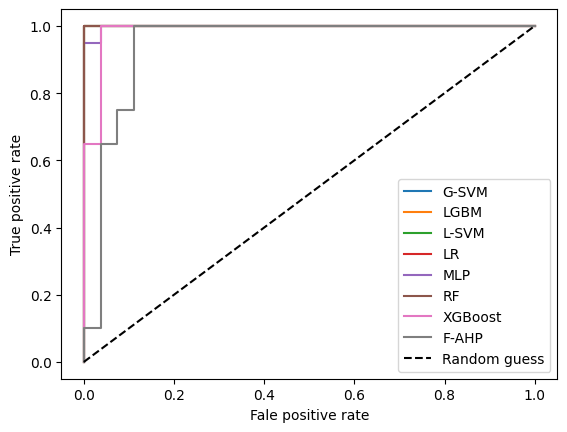

In [13]:
labels = {
    'gaussian_svm': 'G-SVM', 'lgbm': 'LGBM', 'linear_svm': 'L-SVM', 'lr': 'LR',
    'mlp': 'MLP', 'rf': 'RF', 'xgb': 'XGBoost', 'fahp': 'F-AHP'
}
for name in scores.keys():
    plt.plot(fpr_test[name], tpr_test[name], label=labels[name])
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('Fale positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.savefig(results_path / 'rocs.svg', bbox_inches='tight')
plt.show()

In [20]:
data = {'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1-score': [], 'auc': []}
for model in scores.keys():
    data['model'].append(model)
    data['auc'].append(float(roc_auc_score(y[idx_test], scores[model][idx_test])))
    report = classification_report(
        y[idx_test], predictions[model][idx_test], output_dict=True, zero_division=np.nan
    )
    data['accuracy'].append(report['accuracy'])
    for k in ['precision', 'recall', 'f1-score']:
        data[k].append(report['1'][k])

data = pd.DataFrame(data)
data.iloc[:, 1:] = np.round(data.iloc[:, 1:] * 100, 1)
data

,model,accuracy,precision,recall,f1-score,auc
0,gaussian_svm,100.0,100.0,100.0,100.0,100.0
1,lgbm,100.0,100.0,100.0,100.0,100.0
2,linear_svm,95.7,90.9,100.0,95.2,100.0
3,lr,100.0,100.0,100.0,100.0,100.0
4,mlp,97.9,95.2,100.0,97.6,99.8
5,rf,100.0,100.0,100.0,100.0,100.0
6,xgb,95.7,90.9,100.0,95.2,98.7
7,fahp,93.6,87.0,100.0,93.0,94.4


In [25]:
def make_box_plots(ax, scores, idx, labels):
    data = {
        'classifier': [],
        'score': [],
        'avalanche': []
    }
    for model in scores.keys():
        data['classifier'].extend([labels[model]] * len(idx))
        data['score'].extend(scores[model][idx])
        data['avalanche'].extend(y[idx])

    sns.boxplot(ax=ax, data=data, y='classifier', x='score', hue='avalanche', orient='h')

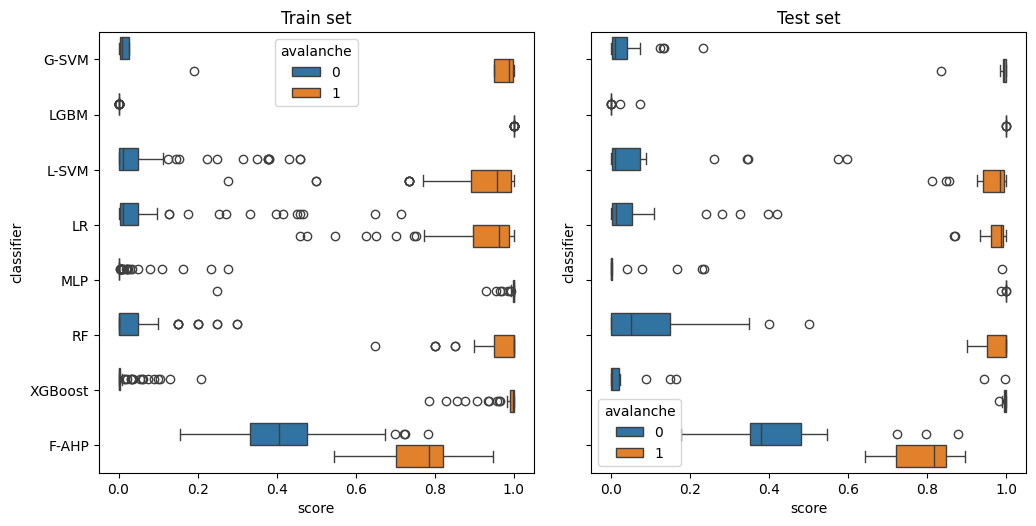

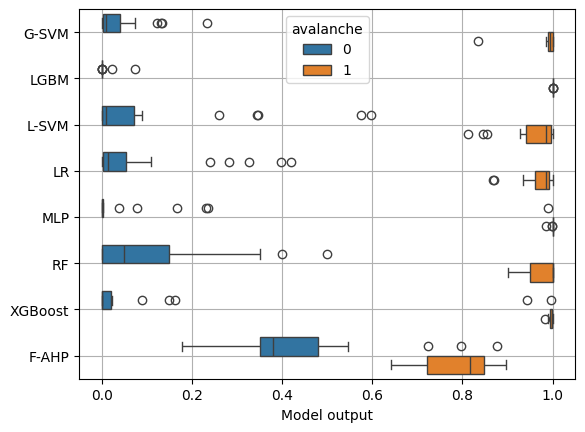

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()

make_box_plots(ax[0], scores, idx_train, labels)
ax[0].set_title('Train set')
make_box_plots(ax[1], scores, idx_test, labels)
ax[1].set_title('Test set')
ax[1].set_yticklabels([])
plt.show()

fig, ax = plt.subplots()
make_box_plots(ax, scores, idx_test, labels)
ax.set_xlabel('Model output')
ax.set_ylabel('')
plt.grid()
fig.savefig(results_path / 'score_bar_plots.svg', bbox_inches='tight')
